In [1]:
import sys
sys.path.append('../')

from quantumsim import *
from pennylane import numpy as np
import matplotlib.pyplot as plt



def molecular_energies(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity,
    )[0]

    # Obtain the matrix representation of the Hamiltonian
    ee = qml.eigvals(hamiltonian)
    return np.sort(ee)

In [17]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x, 0.0, x/2, np.sqrt(x*x - (x*x)/4)], requires_grad=True)

symbols = ["H", "H", "H"]
params = {
    'mapping': "jordan_wigner",
    'charge': 1, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}
coordinates = space(7.0)

system = adap_molecular(symbols, coordinates, params)
#system = vqe_molecular(symbols, coordinates, params)

In [18]:
ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 2,
        }

system.set_device( ansatz_params )
system.set_state( ansatz_params["electrons"] )
system.begin_state = np.array([1,0,1,0,0,0])
system.set_node( ansatz_params )

In [19]:
minimizate_params = {
    "maxiter": 20,
    "qubits": system.qubits,
    "electrons": 2,
    "theta":["generic", 0.3]}

optimizer = adap_optimizer(minimizate_params)
energy1 = optimizer.MinimumCircuit(system.node)
print(energy1)

8
([[0, 4]], [])


In [22]:
system = vqe_molecular(symbols, coordinates, params)


ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 2,
            "qubits": system.qubits,
        }

ansazt = custom_ansatz()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )
ansazt.begin_state = np.array([1,0,1,0,0,0])
#ansazt.set_gates( circuit[0], circuit[1] )
ansazt.excitations = [[0, 4]]#circuit[0]

minimizate_params = {
    "maxiter": 100,
    "tol": 1e-6,
    "number":  1,#len(circuit[0]),
    "theta":["generic", 0.1]}

system.node = ansazt.node
optimizer = gradiend_optimizer(minimizate_params)
energy1, optimum = optimizer.VQE( system.cost_function )
print( energy1[-1], len(energy1) )

-0.9217104166943678 2


In [23]:
optimum

tensor([0.00469257], requires_grad=True)

In [15]:
molecular_energies(symbols, np.array([0., 0., 0.,  0., 0., 1.74652],requires_grad=True ), "sto-3g", charge=1)

/Users/jnorambu/Documents/vqesimulation/venv/lib/python3.9/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


tensor([-3.12268056, -3.12268056, -2.86264925, -2.63699222, -2.19283043,
        -2.19283043, -2.19283043, -2.18030279, -2.18030279, -2.02310538,
        -1.35370023, -1.35370023, -0.69157651, -0.16715658, -0.16715658,
         1.14513432], requires_grad=True)

In [3]:
symbols = ["H", "He"]
coordinates = np.array([0., 0., 0.,  0., 0., 1.2],requires_grad=True )
params = {
    'mapping': "jordan_wigner",
    'charge': 1, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

system = structure_molecular(symbols, coordinates, params)

In [4]:
ansatz_params = {
    "repetitions": 1,
    "base": "default.qubit",
    "interface": "autograd",
    "electrons": 2,
    "qubits": system.qubits
}

ansazt = uccds_ansatz_structure()
ansazt.set_device( ansatz_params )
ansazt.set_node( ansatz_params )
ansazt.set_state( ansatz_params["electrons"] )

In [6]:
def bound_distance(x):
    return np.sqrt( (x[0]-x[3])**2 + (x[1]-x[4])**2 + (x[2]-x[5])**2 )/1.8897259  

lr = [0.4, 0.6, 0.8]

In [21]:
x_evol = []
for j in range(3):
    aux = []
    for i in range(10):
        minimizate_params = {
        "maxiter": 100,
        "tol": 1e-6,
        "number":  len(ansazt.singles) + len(ansazt.doubles),
        "theta":["generic", 0.20],
        "x":["generic", lr[j]]}

        system.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)

        x, x_ev, theta = optimizer.OS(system.cost_function, coordinates, system.grad_x)
        aux.append(x_ev)
        print(x, bound_distance(x))
    x_evol.append(aux)


[ 0.          0.         -0.26315673  0.          0.          1.46315673] 0.913525847701329
[ 0.          0.         -0.26315669  0.          0.          1.46315669] 0.9135258134257721
[ 0.         0.        -0.2631569  0.         0.         1.4631569] 0.9135260278791797
[ 0.          0.         -0.26315667  0.          0.          1.46315667] 0.9135257827318958
[ 0.         0.        -0.2631568  0.         0.         1.4631568] 0.9135259250211558
[ 0.          0.         -0.26315681  0.          0.          1.46315681] 0.9135259371613569
[ 0.          0.         -0.26315672  0.          0.          1.46315672] 0.9135258370834873
[ 0.          0.         -0.26315658  0.          0.          1.46315658] 0.913525690854628
[ 0.          0.         -0.26315664  0.          0.          1.46315664] 0.9135257562437836
[ 0.         0.        -0.2631568  0.         0.         1.4631568] 0.9135259256209719
[ 0.          0.         -0.26315356  0.          0.          1.46315356] 0.91352249833272

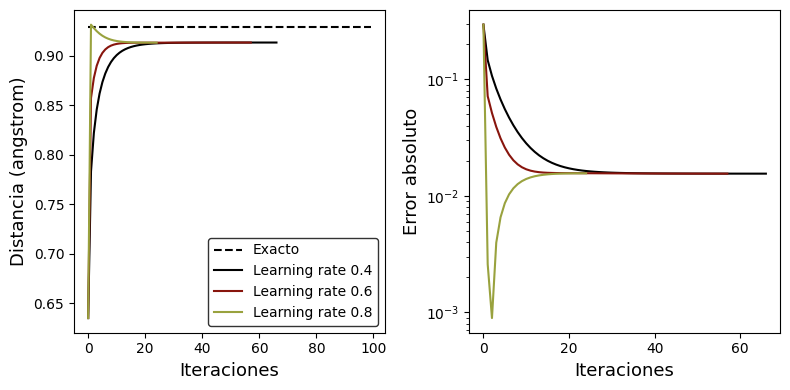

In [36]:
import cmasher as cmr

itera = 100
ex = 0.929
n = 5

cycle = [cmr.apple(i /3) for i in range(3)]
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Distancia (angstrom)", fontsize=13)
ax[1].set_ylabel("Error absoluto", fontsize=13)

ax[0].plot([j for j in range(itera)], [ex for j in range(itera)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(3):
    ax[0].plot([j for j in range(len(x_evol[i][n]))], [bound_distance(j) for j in x_evol[i][n]], label="Learning rate "+str(lr[i]), color = cycle[i])
    ax[1].plot([j for j in range(len(x_evol[i][n]))], [abs(bound_distance(j)-ex) for j in x_evol[i][n]],
               "-", label="Exacto",  color = cycle[i])

ax[1].set_yscale("log")
ax[0].legend(loc="lower right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [45]:
lr = [0.001, 0.01, 0.1]

In [48]:

x_evol_2 = []
for i in range(3):
    minimizate_params = {
        "maxiter": 250,
        "tol": 1e-6,
        "number":  len(ansazt.singles) + len(ansazt.doubles),
        "theta":["generic", 0.20],
        "x":["adam", lr[i]]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)

    x, x_ev, theta = optimizer.OS(system.cost_function, coordinates, system.grad_x)
    x_evol_2.append(x_ev)
    print(x, bound_distance(x))

[ 0.          0.         -0.26316297  0.          0.          1.46316297] 0.9135324542062594
[ 0.          0.         -0.26315893  0.          0.          1.46315893] 0.913528183909532
[ 0.          0.         -0.26315989  0.          0.          1.46315989] 0.9135291941599587


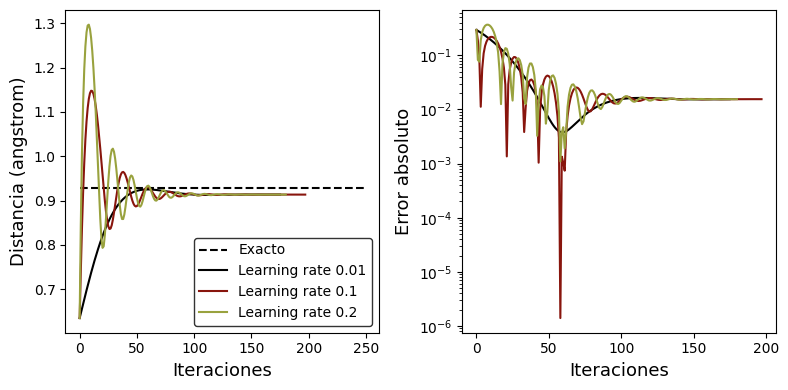

In [49]:
import cmasher as cmr

itera = 250
ex = 0.929
n = 0

cycle = [cmr.apple(i /3) for i in range(3)]
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Distancia (angstrom)", fontsize=13)
ax[1].set_ylabel("Error absoluto", fontsize=13)

ax[0].plot([j for j in range(itera)], [ex for j in range(itera)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(3):
    ax[0].plot([j for j in range(len(x_evol_2[i]))], [bound_distance(j) for j in x_evol_2[i]], label="Learning rate "+str(lr[i]), color = cycle[i])
    ax[1].plot([j for j in range(len(x_evol_2[i]))], [abs(bound_distance(j)-ex) for j in x_evol_2[i]],
               "-", label="Exacto",  color = cycle[i])

ax[1].set_yscale("log")
ax[0].legend(loc="lower right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [7]:
x_evol_3 = []
energy_evol_3 = []
for i in range(10):
    minimizate_params = {
        "maxiter": 250,
        "tol": 1e-6,
        "number":  len(ansazt.singles) + len(ansazt.doubles),
        "theta":["generic", 0.20],
        "x":["generic", 0.6]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)

    x, x_ev, theta, energy_ev = optimizer.OS(system.cost_function, coordinates, system.grad_x)
    
    x_evol_3.append(x_ev)
    energy_evol_3.append(energy_ev)
    print(x, bound_distance(x))

[ 0.          0.         -0.26315329  0.          0.          1.46315329] 0.9135222139069865
[ 0.          0.         -0.26315374  0.          0.          1.46315374] 0.9135226870613686
[ 0.          0.         -0.26315379  0.          0.          1.46315379] 0.9135227419445913
[ 0.          0.         -0.26315359  0.          0.          1.46315359] 0.9135225281691648
[ 0.          0.         -0.26315307  0.          0.          1.46315307] 0.9135219724614175
[ 0.          0.         -0.26315378  0.          0.          1.46315378] 0.9135227297837731
[ 0.          0.         -0.26315374  0.          0.          1.46315374] 0.9135226867008548
[ 0.          0.         -0.26315315  0.          0.          1.46315315] 0.9135220606751084
[ 0.          0.         -0.26315375  0.          0.          1.46315375] 0.9135226931719249
[ 0.          0.         -0.26315354  0.          0.          1.46315354] 0.9135224706760212


In [9]:
for i in range (10):
    print(bound_distance(x_evol_3[i][-1]), energy_evol_3[i][-1])

0.9135222139069865 -2.862694845426616
0.9135226870613686 -2.862694846983545
0.9135227419445913 -2.862694848654691
0.9135225281691648 -2.8626948447797123
0.9135219724614175 -2.862694838266004
0.9135227297837731 -2.8626948482292485
0.9135226867008548 -2.8626948466724818
0.9135220606751084 -2.8626948381419965
0.9135226931719249 -2.862694841239249
0.9135224706760212 -2.8626948426508623


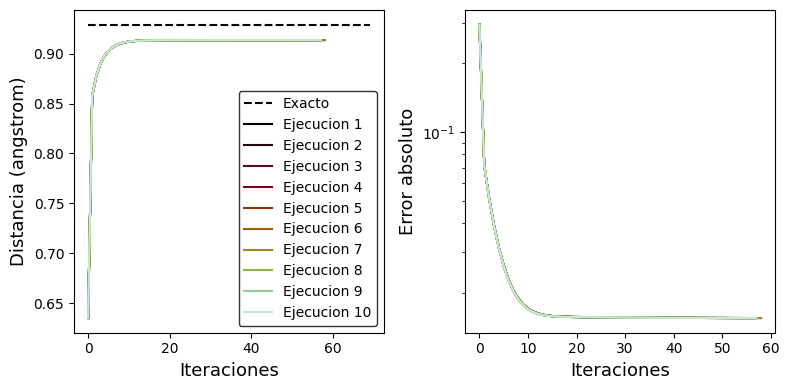

In [18]:
import cmasher as cmr

itera = 70
ex = 0.929
n = 0

cycle = [cmr.apple(i /10) for i in range(10)]
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Distancia (angstrom)", fontsize=13)
ax[1].set_ylabel("Error absoluto", fontsize=13)

ax[0].plot([j for j in range(itera)], [ex for j in range(itera)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(10):
    ax[0].plot([j for j in range(len(x_evol_3[i]))], [bound_distance(j) for j in x_evol_3[i]], label="Ejecucion "+str(i+1), color = cycle[i])
    ax[1].plot([j for j in range(len(x_evol_3[i]))], [abs(bound_distance(j)-ex) for j in x_evol_3[i]],
               "-", label="Exacto",  color = cycle[i])

ax[1].set_yscale("log")
ax[0].legend(loc="lower right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

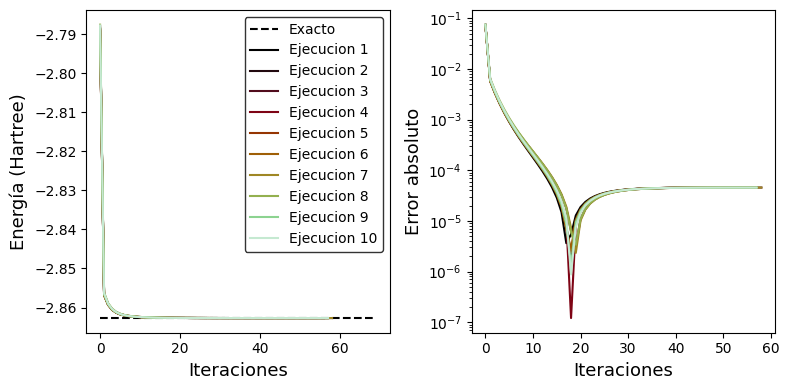

In [27]:
import cmasher as cmr

itera = 70
ex = -2.86264925
n = 0

cycle = [cmr.apple(i /10) for i in range(10)]
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Energía (Hartree)", fontsize=13)
ax[1].set_ylabel("Error absoluto", fontsize=13)

ax[0].plot([j for j in range(itera)], [ex for j in range(itera)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(10):
    ax[0].plot([j for j in range(len(energy_evol_3[i]))], [j for j in energy_evol_3[i]], label="Ejecucion "+str(i+1), color = cycle[i])
    ax[1].plot([j for j in range(len(energy_evol_3[i]))], [abs(j-ex) for j in energy_evol_3[i]],
               "-", label="Exacto",  color = cycle[i])

ax[1].set_yscale("log")
ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [24]:
minimizate_params = {
        "maxiter": 60,
        "tol": 1e-6,
        "number":  len(ansazt.singles) + len(ansazt.doubles),
        "theta":["generic", 0.1],
        "x":["generic", 0.6]}

system.node = ansazt.node
optimizer = gradiend_optimizer(minimizate_params)

x, x_ev, theta, energy_ev = optimizer.OS(system.cost_function, coordinates, system.grad_x)
    

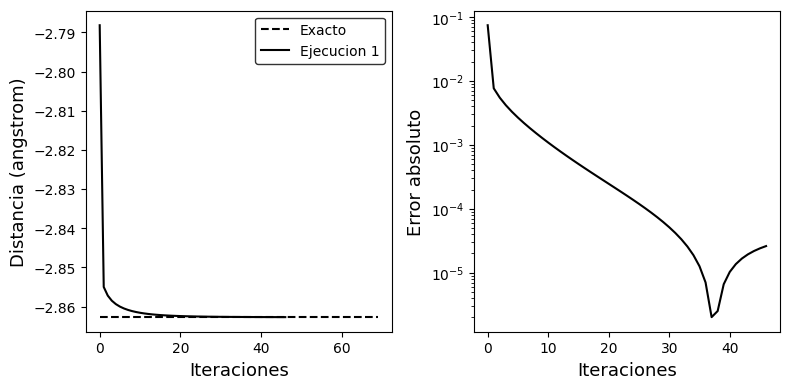

In [26]:
import cmasher as cmr

itera = 70
ex = -2.86264925
n = 0

cycle = [cmr.apple(i /10) for i in range(10)]
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Distancia (angstrom)", fontsize=13)
ax[1].set_ylabel("Error absoluto", fontsize=13)

ax[0].plot([j for j in range(itera)], [ex for j in range(itera)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(1):
    ax[0].plot([j for j in range(len(energy_ev))], [j for j in energy_ev], label="Ejecucion "+str(i+1), color = cycle[i])
    ax[1].plot([j for j in range(len(energy_ev))], [abs(j-ex) for j in energy_ev],
               "-", label="Exacto",  color = cycle[i])

ax[1].set_yscale("log")
ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

In [5]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x], requires_grad=True)

symbols = ["N", "N"]
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

d = 2.0492
system = vqe_molecular(symbols, space(d), params)
system.set_group_characteristics()

KeyboardInterrupt: 

## Uso de memoria

In [2]:
from pympler import asizeof

def molecular_memoria(symbols, coordinates, basis_set, charge=0):
    multiplicity = 1
    # Generate the molecular Hamiltonian
    hamiltonian, qubits = qml.qchem.molecular_hamiltonian(
        symbols = symbols,
        coordinates = coordinates,
        basis=basis_set,
        charge=charge,
        mult=multiplicity
    )

    return [asizeof.asizeof(hamiltonian), qubits]

In [4]:
coordinates = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 1.5])
symbols = [["H", "H"], ["He", "He"], ["Li", "Li"], ["Be", "Be"], ["B", "B"], ["C", "C"], ["N", "N"]]

for i in symbols:
    print(molecular_memoria(i, coordinates, "sto-3g"))

[43296, 4]
[43016, 4]
[30372976, 20]
[22640184, 20]
[30322624, 20]
[42388192, 20]
[30917104, 20]


In [8]:
for i in symbols:
    params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf'
    }

    system = vqe_molecular(i, coordinates, params)
    system.set_group_characteristics()
    print( asizeof.asizeof(system) )

4864
4856
9149400
8948664
9194808
9434560
9195688


## Li-H

In [8]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x], requires_grad=True)

symbols = ["Li", "H"]
params = {
    'mapping': "jordan_wigner",
    'charge': 0, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
    'active_electrons': 2,
    'active_orbitals': 5,
}

distance = 2.998412
#molecule1 = vqe_molecular(symbols, coordinates, params)
#molecule1.set_group_characteristics()

In [9]:
distance = np.round(np.linspace(2, 7, 12),2)

for j in range(10):
    for d in distance:
        system = vqe_molecular(symbols, space(d), params)
        system.set_group_characteristics()
        aux = []
        ansatz_params = {
            "repetitions": 1,
            "base": "default.qubit",
            "interface": "autograd",
            "electrons": 2,
            "qubits": system.qubits
        }

        differents_ansatz = []
        parameters = []

        ansazt = upccgsd_ansatz()
        ansazt.set_device( ansatz_params )
        ansazt.set_node( ansatz_params )
        ansazt.set_state( ansatz_params["electrons"] )
        a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

        minimizate_params = {
                "type": "SLSQP",
                "maxiter": 60,
                "tol": 1e-6,
                "number":  a*b,
                "theta":["generic", 0.3]}

        system.node = ansazt.node
        optimizer = gradiend_optimizer(minimizate_params)
        energy1, optimum = optimizer.VQE(system.cost_function)
        print( d, energy1[-1], len(energy1))

2.0 -7.793548944549091 11
2.4545454545454546 -7.851814269633225 9
2.909090909090909 -7.863213624646201 10
3.3636363636363633 -7.8515997950605705 11
3.8181818181818183 -7.8286795898524275 13


KeyboardInterrupt: 

In [3]:
system = vqe_molecular(symbols, space(distance), params)
system.set_group_characteristics()

values = []
for i in range(3):
    print(i)
    ansatz_params = {
        "repetitions": i+1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 60,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    values.append(energy1)

   

0
1
2


KeyboardInterrupt: 

IndexError: list index out of range

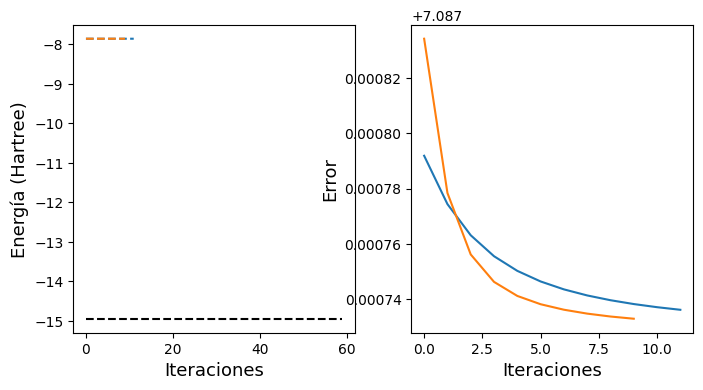

In [6]:
ex = -14.95
fig, ax = plt.subplots(1, 2, figsize=(8,4),)
ax[0].set_xlabel("Iteraciones", fontsize=13)
ax[1].set_xlabel("Iteraciones", fontsize=13)
ax[0].set_ylabel("Energía (Hartree)", fontsize=13)
ax[1].set_ylabel("Error", fontsize=13)

ax[0].plot([j for j in range(60)], [ex for j in range(60)], marker='', color="black", ls="dashed", label="Exacto")
for i in range(7):
    ax[0].plot([j for j in range(len(values[i]))], values[i], ls="dashed", label="HE k="+str(i+1))
    ax[1].plot([j for j in range(len(values[i]))], [abs(values[i][j]-ex) for j in range(len(values[i]))],"-", label="Exacto")

ax[1].set_yscale("log")
ax[0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=2)

fig.tight_layout()
plt.show()

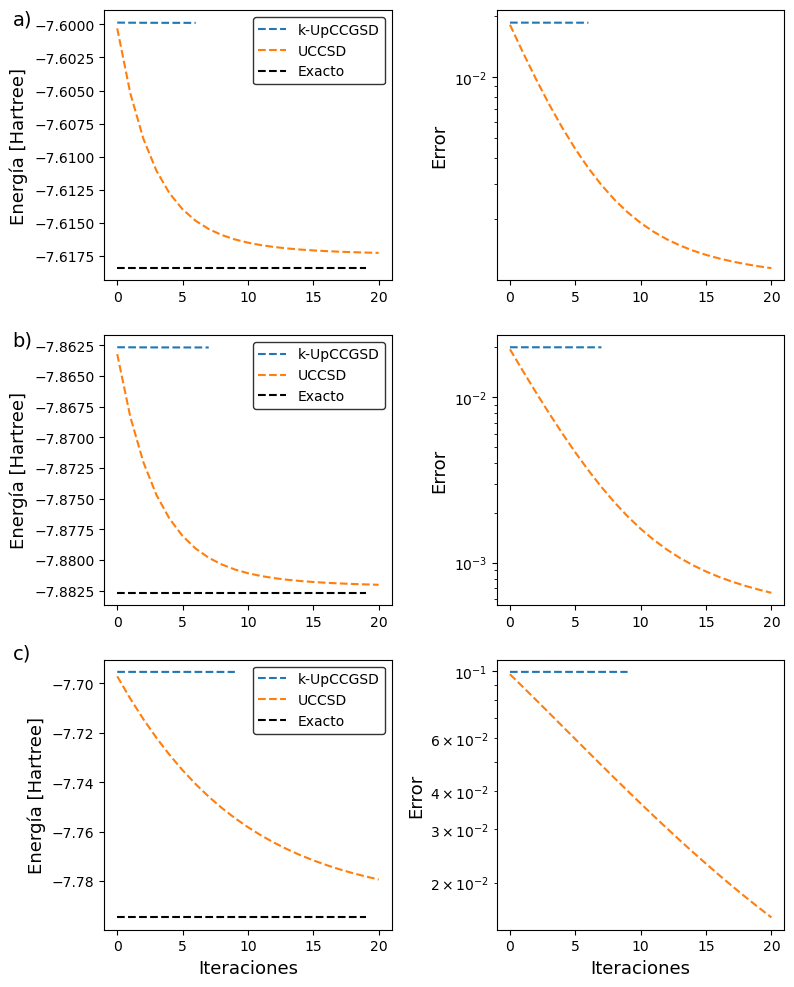

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(8,10),)
ax[2][0].set_xlabel("Iteraciones", fontsize=13)
ax[2][1].set_xlabel("Iteraciones", fontsize=13)

ax[0][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)
ax[2][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[2][1].set_ylabel("Error", fontsize=13)
aux = 20

for i in range(3):
    ax[i][0].plot([j for j in range(len(valores[i][0]))], valores[i][0], ls="dashed", label="k-UpCCGSD")
    ax[i][0].plot([j for j in range(len(valores[i][1]))], valores[i][1], ls="dashed", label="UCCSD")
    ax[i][0].plot([j for j in range( aux ) ], [ee_final[i] for j in range(aux)], color="black", ls="dashed", label="Exacto")

    ax[i][1].plot([j for j in range(len(valores[i][0]))], [np.abs(valores[i][0][j] -ee_final[i]) for j in range(len(valores[i][0]))], 
        ls="dashed", label="kUpCCGSD")
    ax[i][1].plot([j for j in range(len(valores[i][1]))], [np.abs(valores[i][1][j] -ee_final[i]) for j in range(len(valores[i][1]))], 
        ls="dashed", label="UCCSD")
    ax[i][1].set_yscale("log")

    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)

ax[0][0].text(-8, -7.6, 'a)', fontsize=14, color='black')
ax[1][0].text(-8, -7.8625, 'b)', fontsize=14, color='black')
ax[2][0].text(-8, -7.69, 'c)', fontsize=14, color='black')
fig.tight_layout()
plt.show()

### Grafica del potencial

In [21]:
potencial_k = []

for d in np.linspace(1, 5, 20):
    print(d)

    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_k.append(energy1[-1])


1.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4210526315789473
+1
+1
+1
+1
+1
+1
1.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.8421052631578947
+1
+1
+1
+1
+1
+1
+1
2.052631578947368
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.263157894736842
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.473684210526316
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.894736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3157894736842106
+1
+1
+1
+1
+1
+1
+1
+1
3.526315789473684
+1
+1
+1
+1
+1
+1
+1
+1
3.7368421052631575
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.9473684210526314
+1
+1
+1
+1
+1
+1
+1
4.157894736842105
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.368421052631579
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.578947368421052
+1
+1
+1
+1
+1
+1
+1
+1
4.789473684210526
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
5.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


In [24]:
potencial_uc = []

for d in np.linspace(1, 5, 20):
    print(d)
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 2,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_uc.append(energy1[-1])

1.0
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.8421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.052631578947368
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.263157894736842
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.473684210526316
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.894736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3157894736842106
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.526315789473684
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1


In [46]:
ee_final = []
for d in np.linspace(1, 5, 20):
    print( d )
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"])
    ee_final.append(ee[0])

1.0


/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


1.2105263157894737
1.4210526315789473
1.631578947368421
1.8421052631578947
2.052631578947368
2.263157894736842
2.473684210526316
2.6842105263157894
2.894736842105263
3.1052631578947367
3.3157894736842106
3.526315789473684
3.7368421052631575
3.9473684210526314
4.157894736842105
4.368421052631579
4.578947368421052
4.789473684210526
5.0


In [47]:
potencial_k = pd.read_csv("lih_potencial_kup.csv")["0"].values
potencial_uc = pd.read_csv("lih_potencial_uc.csv")["0"].values


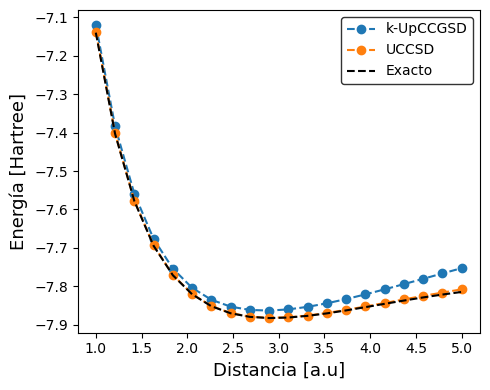

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Distancia [a.u]", fontsize=13)
ax.set_ylabel("Energía [Hartree]", fontsize=13)

ax.plot(np.linspace(1, 5, 20), potencial_k, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(np.linspace(1, 5, 20), potencial_uc, marker='o', ls="dashed", label="UCCSD")
ax.plot(np.linspace(1, 5, 20), ee_final, color="black", ls="dashed", label="Exacto")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()

## Trimero

In [2]:
def space(x):
    return np.array([0.0, 0.0, 0.0, 0.0, 0.0, x, 0.0, x/2, np.sqrt(x*x - (x*x)/4)], requires_grad=True)

symbols = ["H", "H", "H"]
params = {
    'mapping': "jordan_wigner",
    'charge': 1, 
    'mult': 1,
    'basis': 'sto-3g',
    'method': 'dhf',
}

distance = [0.850376694, 1.700753389, 3.401506778]

In [3]:
valores_hydrogen = []

for d in distance:
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    aux.append(energy1)


    valores_hydrogen.append(aux)

0.850376694
kupccgsd
0.4756953693924743
0.47417788018315976
0.47370163756713146
0.4735408992460129
0.47348633080125013
0.4734677482000558
0.4734613834713253
0.4734591787024189
uccsd
0.47341109673796156
0.46899425051371496
0.46764565924861756
0.46709295484020774
0.4668128873676573
0.466654600467694
0.46656058588953453
0.466503419447735
0.46646822402778565
0.46644639262621357
0.46643278138891225
0.4664242612774468
0.4664189089086195
0.466415534234354
0.46641339774263224
0.4664120384860337
1.700753389
kupccgsd
-1.2439959277186057
-1.2481841439386543
-1.2505326872710376
-1.2518450047595642
-1.2525764827944583
-1.2529836258246716
-1.2532100646260358
-1.2533359477846502
-1.2534059132904087
-1.253444795281171
-1.2534664019952488
-1.253478408611674
-1.2534850805789288
-1.2534887881965036
-1.2534908485825664
-1.253491993619396
uccsd
-1.243495846940524
-1.2517401601804985
-1.2561377358571397


KeyboardInterrupt: 

In [6]:
ee_final = []
for d in distance:
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"], charge=1)
    ee_final.append(ee[0])

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


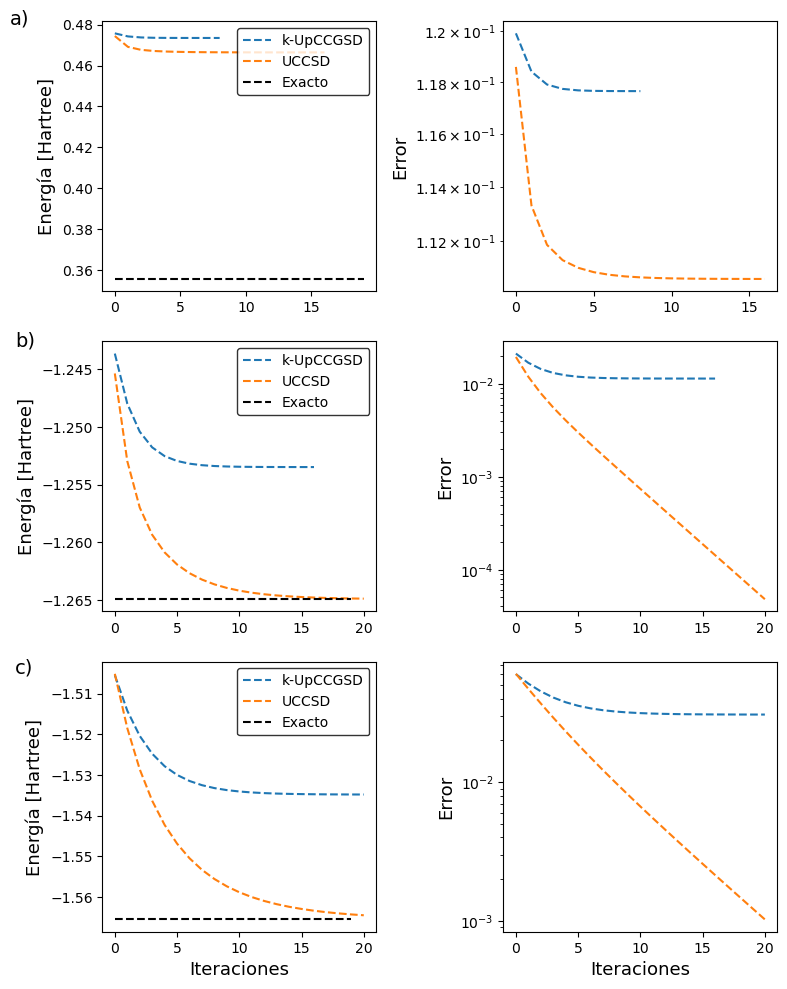

In [24]:
fig, ax = plt.subplots(3, 2, figsize=(8,10),)
ax[2][0].set_xlabel("Iteraciones", fontsize=13)
ax[2][1].set_xlabel("Iteraciones", fontsize=13)

ax[0][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[0][1].set_ylabel("Error", fontsize=13)
ax[1][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[1][1].set_ylabel("Error", fontsize=13)
ax[2][0].set_ylabel("Energía [Hartree]", fontsize=13)
ax[2][1].set_ylabel("Error", fontsize=13)
aux = 20

for i in range(3):
    ax[i][0].plot([j for j in range(len(valores_hydrogen[i][0]))], valores_hydrogen[i][0], ls="dashed", label="k-UpCCGSD", marker='o')
    ax[i][0].plot([j for j in range(len(valores_hydrogen[i][1]))], valores_hydrogen[i][1], ls="dashed", label="UCCSD", marker='o')
    ax[i][0].plot([j for j in range( aux ) ], [ee_final[i] for j in range(aux)], color="black", ls="dashed", label="Exacto", marker='o')

    ax[i][1].plot([j for j in range(len(valores_hydrogen[i][0]))], [np.abs(valores_hydrogen[i][0][j] -ee_final[i]) for j in range(len(valores_hydrogen[i][0]))], 
        ls="dashed", label="kUpCCGSD")
    ax[i][1].plot([j for j in range(len(valores_hydrogen[i][1]))], [np.abs(valores_hydrogen[i][1][j] -ee_final[i]) for j in range(len(valores_hydrogen[i][1]))], 
        ls="dashed", label="UCCSD")
    ax[i][1].set_yscale("log")

    ax[i][0].legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)

ax[0][0].text(-8, 0.48, 'a)', fontsize=14, color='black')
ax[1][0].text(-8, -1.243, 'b)', fontsize=14, color='black')
ax[2][0].text(-8, -1.505, 'c)', fontsize=14, color='black')
fig.tight_layout()
plt.show()

In [26]:
potencial_k_hydrogen = []

for d in np.linspace(0.5, 5, 20):
    print(d)

    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()
    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits
    }

    differents_ansatz = []
    parameters = []

    ansazt = upccgsd_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )
    a,b = qml.kUpCCGSD.shape(k=ansatz_params["repetitions"], n_wires=system.qubits, delta_sz=0)

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 1e-6,
            "number":  a*b,
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_k_hydrogen.append(energy1[-1])

0.5
+1
+1
+1
+1
+1
+1
0.7368421052631579
+1
+1
+1
+1
+1
+1
+1
0.9736842105263157
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4473684210526314
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.9210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.1578947368421053
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.394736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.8684210526315788
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.5789473684210527
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.81578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
4.052631578947368
+1

In [27]:
potencial_uc_hydrogen = []

for d in np.linspace(0.5, 5, 20):
    print(d)
    system = vqe_molecular(symbols, space(d), params)
    system.set_group_characteristics()

    ansatz_params = {
        "repetitions": 1,
        "base": "default.qubit",
        "interface": "autograd",
        "electrons": 3,
        "qubits": system.qubits,
        "pattern": "chain"
    }

    differents_ansatz = []
    parameters = []

    ansazt = uccds_ansatz()
    ansazt.set_device( ansatz_params )
    ansazt.set_node( ansatz_params )
    ansazt.set_state( ansatz_params["electrons"] )

    minimizate_params = {
            "type": "SLSQP",
            "maxiter": 20,
            "tol": 0.000001,
            "number":  len(ansazt.singles) + len(ansazt.doubles),
            "theta":["generic", 0.3]}

    system.node = ansazt.node
    optimizer = gradiend_optimizer(minimizate_params)
    energy1, optimum = optimizer.VQE(system.cost_function)
    potencial_uc_hydrogen.append(energy1[-1])

0.5
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
0.7368421052631579
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
0.9736842105263157
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.2105263157894737
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.4473684210526314
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.6842105263157894
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
1.9210526315789473
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.1578947368421053
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.394736842105263
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.631578947368421
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
2.8684210526315788
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.1052631578947367
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.3421052631578947
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
+1
3.5789473684210527
+1
+1
+1
+1
+

In [28]:
ee_final = []
for d in np.linspace(0.5, 5, 20):
    ee = molecular_energies(symbols=symbols, coordinates=space(d), basis_set=params["basis"], charge=1)
    ee_final.append(ee[0])

/Users/jmflorez/miniconda3/envs/quantum-computing/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


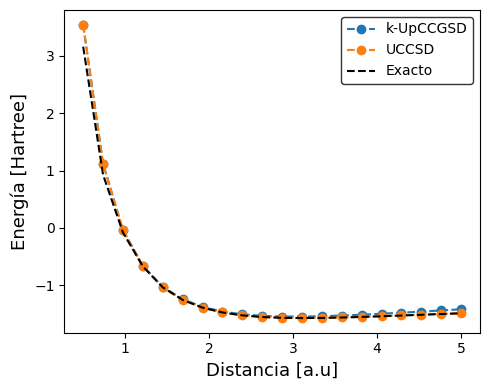

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5,4),)
ax.set_xlabel("Distancia [a.u]", fontsize=13)
ax.set_ylabel("Energía [Hartree]", fontsize=13)

ax.plot(np.linspace(0.5, 5, 20), potencial_k_hydrogen, marker='o', ls="dashed", label="k-UpCCGSD")
ax.plot(np.linspace(0.5, 5, 20), potencial_uc_hydrogen, marker='o', ls="dashed", label="UCCSD")
ax.plot(np.linspace(0.5, 5, 20), ee_final, color="black", ls="dashed", label="Exacto")

ax.legend(loc="upper right", fontsize='medium',frameon=True, edgecolor='k', ncol=1)
fig.tight_layout()
plt.show()